<a href="https://colab.research.google.com/github/Alim20022004/FederatedLearning/blob/main/Federated_Learning_with_Selective_Encryption.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip -q install medmnist
!pip -q install flwr[simulation]
!pip -q install tenseal

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 8.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 125.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 87.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 54.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 42.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 81.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.7/66.7 MB 37.1 MB/s eta 0:00:00
 

In [ ]:
import numpy as np
from collections import OrderedDict
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import transforms
from medmnist import PathMNIST
import flwr as fl
from typing import Dict, List, Tuple
from flwr.common import Context, Metrics
from flwr.common import (
    Code,
    EvaluateIns,
    EvaluateRes,
    FitIns,
    FitRes,
    GetParametersIns,
    GetParametersRes,
    Status,
    ndarrays_to_parameters,
    parameters_to_ndarrays,
)
from flwr.client import Client, ClientApp, NumPyClient
from flwr.common import log
from flwr.common import Scalar,NDArrays
from flwr.server import ServerApp, ServerConfig, ServerAppComponents
from flwr.server.strategy import FedAvg
from flwr.simulation import run_simulation
from torchvision.models import resnet18,ResNet18_Weights,efficientnet_b0, EfficientNet_B0_Weights
import tenseal as ts
import warnings
warnings.filterwarnings('ignore')
import time
import seaborn as sns
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Flower {fl.__version__}")

Flower 1.18.0


In [ ]:
# Cell 2: TenSEAL Context Initialization and Selective CU Library Functions

# Set TenSEAL parameters
poly_modulus_degree = 16384  # High security, adjust if performance is a concern
coeff_mod_bit_sizes = [60, 40, 40, 60]  # Supports multiple operations
global_scale = 2**40  # Precision scaling

# Create a TenSEAL context with CKKS scheme
ts_context = ts.context(
    ts.SCHEME_TYPE.CKKS,
    poly_modulus_degree=poly_modulus_degree,
    coeff_mod_bit_sizes=coeff_mod_bit_sizes
)
ts_context.generate_galois_keys()
ts_context.global_scale = global_scale

# Serialize contexts:
# secret_context: holds the private key (for clients)
secret_context = ts_context.serialize(save_secret_key=True)
# public_context: does not include the private key (for server operations)
public_context = ts_context.serialize()

# Global variable to record (key, shape, sensitive_flag) for each parameter.
# Sensitive flag indicates if the layer should be encrypted.
PARAMETER_INFO = []  # Each element: (key, shape, sensitive)

# Utility: decide whether a parameter is sensitive.
# Here, for example, we mark any parameter whose key contains "classifier" as sensitive.

def deserialization(param_list: list, context: ts.Context) -> list:
    global PARAMETER_INFO
    deserialized_list = []
    for param, (_, shape, sensitive) in zip(param_list, PARAMETER_INFO):
        if sensitive:
            # Convert the NumPy array (encrypted parameter) into bytes
            encrypted_bytes = param.tobytes()
            # Deserialize into a CKKSVector using the provided context
            ckks_vec = ts.ckks_vector_from(context, encrypted_bytes)
            deserialized_list.append(ckks_vec)
        else:
            deserialized_list.append(param)
    return deserialized_list

def selective_plain(param_list: list, context: ts.Context) -> list:
    global PARAMETER_INFO
    decrypted_list = []
    for param, (_, shape, sensitive) in zip(param_list, PARAMETER_INFO):
        if sensitive:
            flat = np.array(param.decrypt())
            decrypted_list.append(flat.reshape(shape))
        else:
            decrypted_list.append(param)
    return decrypted_list


def selective_cipher(params: list, context: ts.Context) -> list:
    global PARAMETER_INFO
    encrypted_list = []
    for param, (_, shape, sensitive) in zip(params, PARAMETER_INFO):
        if sensitive:
          flat_list = param.flatten().tolist()
          ckks_vec = ts.ckks_vector(context, flat_list)
          encrypted_list.append(ckks_vec)
        else:
          encrypted_list.append(param)
    return encrypted_list

def serialization(enc_list: list) -> list:
    global PARAMETER_INFO
    serialized_list = []
    for param, (_, shape, sensitive) in zip(enc_list, PARAMETER_INFO):
        if sensitive:
           serialized = param.serialize()
           np_serialized = np.frombuffer(serialized, dtype=np.uint8)
           serialized_list.append(np_serialized)
        else:
           serialized_list.append(param)
    return serialized_list

def selective_aggregate(param_groups: list, context: ts.Context) -> list:
    """
    param_groups: list of tuples (params, weight), where params is a list of parameters (ordered as in PARAMETER_INFO).
    For each parameter:
      - If sensitive, perform homomorphic weighted aggregation.
      - Otherwise, perform standard weighted averaging.
    Returns an aggregated list of parameters in the same order.
    """
    global PARAMETER_INFO
    num_params = len(PARAMETER_INFO)
    total_weight = sum(weight for (_, weight) in param_groups)
    aggregated = []
    for i in range(num_params):
        _, shape, sensitive = PARAMETER_INFO[i]
        if sensitive:
            agg_vec = None
            for (params, weight) in param_groups:
                param_val = params[i]
                encrypted_bytes = param_val.tobytes()
                ckks_vec = ts.ckks_vector_from(context, encrypted_bytes)
                weighted_vec = ckks_vec * weight
                if agg_vec is None:
                    agg_vec = weighted_vec
                else:
                    agg_vec += weighted_vec
            agg_vec *= (1.0 / total_weight)
            serialized = agg_vec.serialize()
            np_serialized = np.frombuffer(serialized, dtype=np.uint8)
            aggregated.append(np_serialized)
        else:
            # Plain weighted average for non-sensitive parameters.
            agg_plain = None
            for (params, weight) in param_groups:
                param_val = params[i]
                weighted_val = param_val * weight
                if agg_plain is None:
                    agg_plain = weighted_val
                else:
                    agg_plain += weighted_val
            agg_plain /= total_weight
            aggregated.append(agg_plain)
    return aggregated

### --- End Selective CU Library Functions ---


In [ ]:
# Cell 3: Model, Training, and Evaluation Functions

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = 9

from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights

# Initialize EfficientNet-B0 and adjust for the number of classes.
modeleff = efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
modeleff.classifier[1] = nn.Linear(modeleff.classifier[1].in_features, num_classes)
modelefficient = modeleff.to(device)

def train_epoch(model, train_loader):
    model.train()
    correct, total, running_loss = 0, 0, 0.0
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.squeeze().to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    return running_loss / len(train_loader), 100 * correct / total

def validate(model, val_loader):
    model.eval()
    correct, total, val_loss = 0, 0, 0.0
    criterion = nn.CrossEntropyLoss()
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.squeeze().to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    return val_loss / len(val_loader), 100 * correct / total

def evaluate_model(model, test_loader):
    model.eval()
    total, correct, test_loss = 0, 0, 0.0
    all_preds, all_labels = [], []
    criterion = nn.CrossEntropyLoss()
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.squeeze().to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            total += labels.size(0)
            correct += preds.eq(labels).sum().item()
    return test_loss / len(test_loader), 100 * correct / total, np.array(all_preds), np.array(all_labels)


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 192MB/s]


In [ ]:
# Cell 4: Data Loading, Partitioning, and Visualization Functions

BATCH_SIZE = 64
NUM_CLIENTS = 5

def load_full_datasets():
    train_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ColorJitter(0.2, 0.2, 0.2, 0.1),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])
    test_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])
    train_dataset = PathMNIST(split='train', transform=train_transform, download=True)
    val_dataset = PathMNIST(split='val', transform=test_transform, download=True)
    return train_dataset, val_dataset

def load_test_dataset():
    test_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])
    test_dataset = PathMNIST(split='test', transform=test_transform, download=True)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
    return test_loader

def partition_dataset(dataset, num_partitions: int):
    indices = np.random.permutation(len(dataset))
    partitions_indices = np.array_split(indices, num_partitions)
    subsets = [Subset(dataset, idx) for idx in partitions_indices]
    return subsets


# --- Perform data loading and partitioning ONCE globally ---
print("Loading and partitioning datasets globally...")
start_time_data_prep = time.time()

# 1. Load full datasets once
FULL_TRAIN_DATASET, FULL_VAL_DATASET = load_full_datasets()
print(f"Full train dataset size: {len(FULL_TRAIN_DATASET)}")
print(f"Full val dataset size: {len(FULL_VAL_DATASET)}")
# 2. Partition them once
# Choose your partitioning strategy (e.g., Non-IID)
TRAIN_PARTITIONS = partition_dataset(FULL_TRAIN_DATASET, NUM_CLIENTS)
print(f"Train partitions: {len(TRAIN_PARTITIONS)}")

VAL_PARTITIONS = partition_dataset(FULL_VAL_DATASET, NUM_CLIENTS)
print(f"Val partitions: {len(VAL_PARTITIONS)}")
# Or for IID:
# TRAIN_PARTITIONS = partition_dataset(FULL_TRAIN_DATASET, NUM_CLIENTS)
# VAL_PARTITIONS = partition_dataset(FULL_VAL_DATASET, NUM_CLIENTS)

end_time_data_prep = time.time()
print(f"Data loaded and partitioned for {NUM_CLIENTS} clients in {end_time_data_prep - start_time_data_prep:.2f} seconds.")

Loading and partitioning datasets globally...


100%|██████████| 206M/206M [00:43<00:00, 4.68MB/s]


Full train dataset size: 89996
Full val dataset size: 10004
Train partitions: 5
Val partitions: 5
Data loaded and partitioned for 5 clients in 47.65 seconds.


In [ ]:
def load_client_dataloaders(partition_id: int):
    """
    Creates DataLoaders for a specific client using pre-partitioned global data.
    """
    if not (0 <= partition_id < NUM_CLIENTS):
        raise ValueError(f"Partition ID {partition_id} is out of bounds for {NUM_CLIENTS} clients.")

    client_train_subset = TRAIN_PARTITIONS[partition_id]

    train_loader = DataLoader(client_train_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True if device.type == "cuda" else False)
    return train_loader

In [ ]:
def compute_robust_layer_grad_norms(model, data_loader, device, num_batches):
    """
    Computes the average L2 norm of gradients for each parameter over multiple batches.
    """
    model.train()  # Ensure model is in training mode for gradient calculation
    grad_norm_accumulators = {name: 0.0 for name, _ in model.named_parameters()}
    params_with_grads = {name: False for name, _ in model.named_parameters()}
    actual_batches_processed = 0
    criterion = nn.CrossEntropyLoss()
    data_iter = iter(data_loader)

    print(f"Calculating average gradient norms over {num_batches} batches...")
    for i in range(num_batches):
        try:
            inputs, labels = next(data_iter)
            inputs, labels = inputs.to(device), labels.squeeze().to(device)

            # Zero out previous gradients
            model.zero_grad()

            # Forward pass and compute loss
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass to compute gradients for this batch
            loss.backward()

            # Accumulate gradient norms
            for name, param in model.named_parameters():
                if param.grad is not None:
                    grad_norm = param.grad.data.norm(2).item()
                    grad_norm_accumulators[name] += grad_norm
                    params_with_grads[name] = True # Mark that this param had a grad at least once
                elif i == 0: # Print warning only on the first batch if no grad
                    print(f"Warning: Parameter '{name}' has no gradient in batch {i+1}.")

            actual_batches_processed += 1

        except StopIteration:
            print(f"Warning: DataLoader exhausted after {actual_batches_processed} batches (requested {num_batches}). Averaging over available batches.")
            break
        except Exception as e:
            print(f"An error occurred during batch {i+1}: {e}")
            # Optionally decide whether to continue or break
            break

    if actual_batches_processed == 0:
        print("Error: No batches processed. Cannot compute gradient norms.")
        return {name: 0.0 for name, _ in model.named_parameters()} # Return zeros

    # Calculate average norms
    average_grad_norms = {}
    for name, total_norm in grad_norm_accumulators.items():
        if params_with_grads[name]: # Avoid division by zero if a param never got a gradient
             average_grad_norms[name] = total_norm / actual_batches_processed
        else:
             average_grad_norms[name] = 0.0
             print(f"Parameter '{name}' consistently had no gradient.")


    print("Finished calculating average gradient norms.")
    return average_grad_norms

In [ ]:
def load_datasetssen(BATCH_SIZE=64): # This loader is used for gradient calculation
    train_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        # No augmentation needed usually for grad calc, but keep consistent if desired
        # transforms.RandomHorizontalFlip(),
        # transforms.RandomRotation(10),
        # transforms.ColorJitter(0.2, 0.2, 0.2, 0.1),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])
    # Use a portion or the whole train dataset for grad norm calc
    train_dataset = PathMNIST(split='train', transform=train_transform, download=True)
    # Consider using a subset if the full dataset is too large/slow for grad calc
    # subset_indices = np.random.choice(len(train_dataset), size=BATCH_SIZE * 100, replace=False)
    # train_subset = Subset(train_dataset, subset_indices)
    # train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4) # Using full dataset here
    return train_loader
DATA=load_datasetssen()



In [ ]:
def update_parameter_info_hybrid(model, data_loader, device,
                                 mandatory_layer_prefixes=["classifier.1."],
                                 top_fraction_conditional=0.1,
                                 num_batches_for_norm=10 ):
    """
    Updates PARAMETER_INFO using the Hybrid approach.
    - Marks layers starting with `mandatory_layer_prefixes` as sensitive.
    - Calculates robust average gradient norms for other layers.
    - Marks the top `top_fraction_conditional` of these other layers as sensitive.
    - Prints sensitive layers along with their average gradient norm.
    """
    global PARAMETER_INFO
    print("Updating PARAMETER_INFO using Hybrid Approach...")
    print(f"Mandatory prefixes: {mandatory_layer_prefixes}")
    print(f"Conditional top fraction: {top_fraction_conditional * 100}%")
    print(f"Batches for norm calculation: {num_batches_for_norm}")

    state_dict = model.state_dict()
    original_keys = list(state_dict.keys())
    parameter_info_dict = {} # Use a dict to build info, maintaining order later

    # Step 1: Identify mandatory sensitive parameters
    mandatory_keys = set()
    for key in original_keys:
        is_mandatory = False
        for prefix in mandatory_layer_prefixes:
            if key.startswith(prefix):
                is_mandatory = True
                mandatory_keys.add(key)
                break
        # Initialize dict entry for this key
        parameter_info_dict[key] = {
            "shape": state_dict[key].shape,
            "sensitive": is_mandatory,
            "norm": 0.0 # Initialize norm, will be updated
        }
    print(f"Identified {len(mandatory_keys)} mandatory parameters.")

    # Step 2: Compute robust average gradient norms for all parameters
    average_grad_norms = compute_robust_layer_grad_norms(
        model, data_loader, device, num_batches=num_batches_for_norm
    )

    # Store norms and identify parameters eligible for conditional selection
    conditional_candidates = []
    for key in original_keys:
        norm = average_grad_norms.get(key, 0.0)
        parameter_info_dict[key]["norm"] = norm # Store the calculated norm
        if key not in mandatory_keys:
            # Append tuple (key, norm) for sorting conditional candidates
            conditional_candidates.append((key, norm))

    # Step 3: Select top fraction of conditional candidates based on norm
    if top_fraction_conditional > 0 and conditional_candidates:
        # Sort candidates by norm (descending)
        conditional_candidates_sorted = sorted(
            conditional_candidates, key=lambda x: x[1], reverse=True
        )

        # Determine how many conditional parameters to mark as sensitive
        num_conditional_to_select = int(len(conditional_candidates_sorted) * top_fraction_conditional)

        print(f"Selecting top {num_conditional_to_select} conditional parameters (out of {len(conditional_candidates_sorted)}) based on gradient norm.")

        # Mark the selected conditional parameters as sensitive
        for i in range(num_conditional_to_select):
            key_to_mark, norm_value = conditional_candidates_sorted[i] # Unpack key and norm
            parameter_info_dict[key_to_mark]["sensitive"] = True
            # Optional detailed print during selection (can be commented out)
            # print(f"  - Marking conditional: {key_to_mark} (Avg Norm: {norm_value:.4e})")

    # Step 4: Build the final PARAMETER_INFO list, preserving original order
    new_parameter_info = []
    for key in original_keys:
        info = parameter_info_dict[key]
        new_parameter_info.append((key, info["shape"], info["sensitive"]))

    # Update the global variable
    PARAMETER_INFO = new_parameter_info
    print("PARAMETER_INFO updated.")

    # --- ADDED PRINTING SECTION ---
    # Print final summary and list sensitive parameters with their norms
    num_sensitive = sum(1 for _, _, s in PARAMETER_INFO if s)
    num_total = len(PARAMETER_INFO)
    print(f"\nTotal parameters: {num_total}")
    print(f"Number of sensitive parameters (Mandatory + Conditional): {num_sensitive} ({num_sensitive/num_total*100:.2f}%)")

    print("\nSensitive parameters identified (Name: Avg Grad Norm):")
    sensitive_count = 0
    for key, shape, sensitive in PARAMETER_INFO:
        if sensitive:
            # Retrieve the norm stored earlier in parameter_info_dict
            num_params_in_tensor = np.prod(shape)
            norm_value = parameter_info_dict[key]['norm']
            # Print using scientific notation for potentially wide range of values
            print(f"- {key}: {norm_value:.4e} |num prams : {num_params_in_tensor}")
            sensitive_count += 1
    for key, shape, sensitive in PARAMETER_INFO:
        if not sensitive:
         num_params_in_tensor = np.prod(shape)
         norm_value = parameter_info_dict[key]['norm']
         print(f"- {key}: not sensitive {norm_value:.4e} |num prams : {num_params_in_tensor}")
    if sensitive_count == 0:
        print("No sensitive parameters were identified.")
    # --- END OF ADDED PRINTING SECTION ---

    return PARAMETER_INFO

# --- MODIFIED INITIAL CALL ---
# Load data loader needed for gradient calculation
grad_calc_loader = load_datasetssen() # Use the function defined above

# Update PARAMETER_INFO using the hybrid method BEFORE defining client/server logic
update_parameter_info_hybrid(
    modelefficient,  # The instantiated model
    grad_calc_loader,
    device,
    mandatory_layer_prefixes=["classifier"], # Make sure this matches your model structure
    top_fraction_conditional=0.13, # Encrypt mandatory + top 15% of remaining layers by grad norm
    num_batches_for_norm=64 # Number of batches to average gradients over
)

# Verify the number of sensitive layers identified
num_sensitive = sum(1 for _, _, s in PARAMETER_INFO if s)
num_total = len(PARAMETER_INFO)
print(f"Total parameters: {num_total}")
print(f"Number of sensitive parameters (Mandatory + Conditional): {num_sensitive} ({num_sensitive/num_total*100:.2f}%)")



Updating PARAMETER_INFO using Hybrid Approach...
Mandatory prefixes: ['classifier']
Conditional top fraction: 13.0%
Batches for norm calculation: 64
Identified 2 mandatory parameters.
Calculating average gradient norms over 64 batches...
Finished calculating average gradient norms.
Selecting top 46 conditional parameters (out of 358) based on gradient norm.
PARAMETER_INFO updated.

Total parameters: 360
Number of sensitive parameters (Mandatory + Conditional): 48 (13.33%)

Sensitive parameters identified (Name: Avg Grad Norm):
- features.0.0.weight: 1.4886e+00 |num prams : 864
- features.1.0.block.0.0.weight: 4.2400e-01 |num prams : 288
- features.1.0.block.2.0.weight: 2.1017e-01 |num prams : 512
- features.2.0.block.0.0.weight: 2.7777e-01 |num prams : 1536
- features.2.0.block.1.0.weight: 3.7697e-01 |num prams : 864
- features.2.0.block.3.0.weight: 2.2128e-01 |num prams : 2304
- features.2.1.block.0.0.weight: 1.9269e-01 |num prams : 3456
- features.2.1.block.1.0.weight: 1.6177e-01 |nu

In [ ]:
# Cell 5: Utility Functions for Model Parameters and Storing Parameter Info

def get_parameters(model) -> list:
    global PARAMETER_INFO
    state_dict = model.state_dict()
    return [state_dict[key].cpu().numpy() for key, _, _ in PARAMETER_INFO]

def set_parameters(model, parameters: list):
    global PARAMETER_INFO
    new_state = OrderedDict()
    for (key, _, _), param in zip(PARAMETER_INFO, parameters):
        new_state[key] = torch.tensor(param)
    model.load_state_dict(new_state)



In [ ]:
class FlowerClient(fl.client.Client):
    def __init__(self, partition_id, model, train_loader, eval_loader):
        self.partition_id = partition_id
        self.model = model
        self.train_loader = train_loader
        self.eval_loader = eval_loader

    def fit(self, ins):
        timings = {}
        print(f"[Client {self.partition_id}] fit")
        # Convert received parameters to a list of NumPy arrays.
        print("start deserialization")
        start = time.time()
        deserialized_params = parameters_to_ndarrays(ins.parameters)
        # Use the private context (with secret key) to decrypt sensitive parameters.
        private_ts_context = ts.context_from(secret_context)
        encrypted_vectors = deserialization(deserialized_params, private_ts_context)
        timings['deserialization'] = time.time() - start
        print("End deserialization")

        # selective_plain will handle conversion only for sensitive parameters.
        print("start decryption")
        start = time.time()
        plaintext_params = selective_plain(encrypted_vectors, private_ts_context)
        timings['decryption'] = time.time() - start
        print("End Decryption ")
        set_parameters(self.model, plaintext_params)
        print("model loaded")
        # Perform local training.
        print("start training")
        start = time.time()
        train_loss, train_acc = train_epoch(self.model, self.train_loader)
        print(f"Train accuracy : {train_acc}| Train loss :{train_loss}")
        timings['training'] = time.time() - start
        print(f"client{self.partition_id} completed training.")

        # Encrypt updated parameters selectively before sending them back.
        updated_params = get_parameters(self.model)
        print(f"Encryption ...")
        start = time.time()
        public_ts_context = ts.context_from(public_context)
        encrypted_updated = selective_cipher(updated_params, public_ts_context)
        timings['encryption'] = time.time() - start
        print(f"Encryption complete")
        print(f"serialization")
        start = time.time()
        serialized_updated = serialization(encrypted_updated)
        parameters_encrypted = ndarrays_to_parameters(serialized_updated)
        timings['serialization'] = time.time() - start
        print(f"[Client {self.partition_id}] Timing breakdown: {timings}")

        status = Status(code=Code.OK, message="Success")
        return fl.common.FitRes(
            status=status,
            parameters=parameters_encrypted,
            num_examples=len(self.train_loader.dataset),
            metrics = {"deserialization": timings["deserialization"],
                        "decryption": timings["decryption"],
                        "training": timings["training"],
                        "encryption": timings["encryption"],
                        "serialization":timings['serialization']}
        )

    def get_parameters(self, ins):
        current_params = get_parameters(self.model)
        public_ts_context = ts.context_from(public_context)
        encrypted_current = selective_cipher(current_params, public_ts_context)
        return fl.common.GetParametersRes(
            status=Status(code=Code.OK, message="Success"),
            parameters=ndarrays_to_parameters(encrypted_current)
        )

    def evaluate(self, ins):
        print(f"[Client {self.partition_id}] evaluate, config: {ins.config}")
        deserialized_params = parameters_to_ndarrays(ins.parameters)
        # Use the private context (with secret key) to decrypt sensitive parameters.
        private_ts_context = ts.context_from(secret_context)
        encrypted_vectors = deserialization(deserialized_params, private_ts_context)
        plaintext_params = selective_plain(encrypted_vectors, private_ts_context)
        set_parameters(self.model, plaintext_params)

        val_loss, val_acc = validate(self.model, self.eval_loader)
        print(f"Loss : {val_loss:.4f} | Accuracy: {val_acc :.2f} %")
        return fl.common.EvaluateRes(
            status=Status(code=Code.OK, message="Success"),
            loss=float(val_loss),
            num_examples=len(self.eval_loader.dataset),
            metrics={"Accuracy": float(val_acc)}
        )
def client_fn(context: Context) -> fl.client.Client:
    partition_id = context.node_config["partition-id"]
    train_loader = load_client_dataloaders(partition_id)
    print(f"Client {partition_id} initialized. Train samples: {len(train_loader.dataset)}")
    test_loader = load_test_dataset()
    return FlowerClient(partition_id, modelefficient, train_loader,test_loader)

client_app = fl.client.ClientApp(client_fn=client_fn)

In [ ]:
# Cell 7: Custom FedAvg Strategy with Selective Aggregation
global round_times, aggregation_times
round_times = []  # Reset timing data for each simulation
aggregation_times = []  # To store aggregation-specific timing data
class CustomFedAvg(FedAvg):
    def configure_fit(self, server_round, parameters, client_manager):
        global round_times, aggregation_times
        self.round_start_time = time.time()
        return super().configure_fit(server_round, parameters, client_manager)

    def aggregate_fit(self, server_round, results, failures):
        if not results:
            return None, {}
        if not self.accept_failures and failures:
            return None, {}

        global round_times, aggregation_times
        agg_start = time.time()
        weights_results = [
            (parameters_to_ndarrays(fit_res.parameters), fit_res.num_examples)
            for _, fit_res in results
        ]
        public_ts_context = ts.context_from(public_context)
        aggregated_params = selective_aggregate(weights_results, public_ts_context)
        aggregated_parameters = ndarrays_to_parameters(aggregated_params)

        metrics_aggregated = {}
        if self.fit_metrics_aggregation_fn:
            fit_metrics = [(res.num_examples, res.metrics) for _, res in results]
            metrics_aggregated = self.fit_metrics_aggregation_fn(fit_metrics)
        elif server_round == 1:
            print("Warning: No fit_metrics_aggregation_fn provided")
        agg_duration = time.time() - agg_start
        if not failures:
            aggregation_times.append((server_round, agg_duration))
            round_times.append((server_round, time.time() - self.round_start_time))
        # Aggregate metrics if a function is provided.
        return aggregated_parameters, metrics_aggregated


In [ ]:
# Cell 8: Client and Server Setup; Running the Simulation
def weighted_average(metrics):
    total = sum(num_examples for num_examples, _ in metrics)
    val_acc = sum(num_examples * m["Accuracy"] for num_examples, m in metrics)
    return {"Accuracy": val_acc / total}

def avg_metrics(metrics):
    num_clients = len(metrics)
    if num_clients == 0:
        return {}

    aggregated = {
        "deserialization": sum(m["deserialization"] for _, m in metrics) / num_clients,
        "decryption": sum(m["decryption"] for _, m in metrics) / num_clients,
        "training": sum(m["training"] for _, m in metrics) / num_clients,
        "encryption": sum(m["encryption"] for _, m in metrics) / num_clients,
        "serialization": sum(m["serialization"] for _, m in metrics) / num_clients,
    }
    return aggregated

# Encrypt the initial model parameters using selective encryption.
initial_params = get_parameters(modelefficient)
public_ts_context = ts.context_from(public_context)
encrypted_initial = selective_cipher(initial_params, public_ts_context)
serialized_initial = serialization(encrypted_initial)
initial_parameters = ndarrays_to_parameters(serialized_initial)

def server_fn(context: Context) -> ServerAppComponents:
    strategy = CustomFedAvg(
        fraction_fit=1,
        fraction_evaluate=0.1,
        min_available_clients=NUM_CLIENTS,
        min_evaluate_clients=1,
        fit_metrics_aggregation_fn=avg_metrics,
        #evaluate_fn=evaluate_fn,
        initial_parameters=initial_parameters,
        evaluate_metrics_aggregation_fn=weighted_average,
    )
    config = ServerConfig(num_rounds=10)
    return ServerAppComponents(strategy=strategy, config=config)

server_app = ServerApp(server_fn=server_fn)

backend_config = {"client_resources": {"num_cpus": 2, "num_gpus": 1.0}}
if device.type == "cuda":
    backend_config = {"client_resources": {"num_cpus": 2, "num_gpus": 1.0}}




The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_mod

In [ ]:
run_simulation(
    server_app=server_app,
    client_app=client_app,
    num_supernodes=NUM_CLIENTS,
    backend_config=backend_config,
)

DEBUG:flwr:Asyncio event loop already running.
INFO :      Starting Flower ServerApp, config: num_rounds=10, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      Evaluation returned no results (`None`)
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
(pid=3865) 2025-05-31 09:58:21.215745: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=3865) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(pid=3865) E0000 00:00:1748685501.238355    3865 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=3865) E0000 00:00:1748685501.245897    3865 cuda_blas.

(ClientAppActor pid=3865) Client 0 initialized. Train samples: 18000
(ClientAppActor pid=3865) [Client 0] fit
(ClientAppActor pid=3865) start deserialization
(ClientAppActor pid=3865) End deserialization
(ClientAppActor pid=3865) start decryption
(ClientAppActor pid=3865) End Decryption 
(ClientAppActor pid=3865) model loaded
(ClientAppActor pid=3865) start training
(ClientAppActor pid=3865) Train accuracy : 85.59444444444445| Train loss :0.4248435279314822
(ClientAppActor pid=3865) client0 completed training.
(ClientAppActor pid=3865) Encryption ...
(ClientAppActor pid=3865) WARNING: The input does not fit in a single ciphertext, and some operations will be disabled.
(ClientAppActor pid=3865) The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
(ClientAppActor pid=3865) If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
(ClientAppActor pid=3865) WARNING: The input does not fit in a s

INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 1 clients (out of 5)


(ClientAppActor pid=3865) Client 3 initialized. Train samples: 17999
(ClientAppActor pid=3865) [Client 3] evaluate, config: {}


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=3865) Loss : 0.2907 | Accuracy: 91.03 %
(ClientAppActor pid=3865) Client 0 initialized. Train samples: 18000
(ClientAppActor pid=3865) [Client 0] fit
(ClientAppActor pid=3865) start deserialization
(ClientAppActor pid=3865) End deserialization
(ClientAppActor pid=3865) start decryption
(ClientAppActor pid=3865) End Decryption 
(ClientAppActor pid=3865) model loaded
(ClientAppActor pid=3865) start training
(ClientAppActor pid=3865) Train accuracy : 90.97777777777777| Train loss :0.27322780428097604
(ClientAppActor pid=3865) client0 completed training.
(ClientAppActor pid=3865) Encryption ...
(ClientAppActor pid=3865) WARNING: The input does not fit in a single ciphertext, and some operations will be disabled.
(ClientAppActor pid=3865) The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
(ClientAppActor pid=3865) If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
(Cl

INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 1 clients (out of 5)


(ClientAppActor pid=3865) Client 3 initialized. Train samples: 17999
(ClientAppActor pid=3865) [Client 3] evaluate, config: {}


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=3865) Loss : 0.1720 | Accuracy: 93.86 %
(ClientAppActor pid=3865) Client 0 initialized. Train samples: 18000
(ClientAppActor pid=3865) [Client 0] fit
(ClientAppActor pid=3865) start deserialization
(ClientAppActor pid=3865) End deserialization
(ClientAppActor pid=3865) start decryption
(ClientAppActor pid=3865) End Decryption 
(ClientAppActor pid=3865) model loaded
(ClientAppActor pid=3865) start training
(ClientAppActor pid=3865) Train accuracy : 92.87222222222222| Train loss :0.21579096073297954
(ClientAppActor pid=3865) client0 completed training.
(ClientAppActor pid=3865) Encryption ...
(ClientAppActor pid=3865) WARNING: The input does not fit in a single ciphertext, and some operations will be disabled.
(ClientAppActor pid=3865) The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
(ClientAppActor pid=3865) If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
(Cl

INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 1 clients (out of 5)


(ClientAppActor pid=3865) Client 0 initialized. Train samples: 18000
(ClientAppActor pid=3865) [Client 0] evaluate, config: {}


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=3865) Loss : 0.1553 | Accuracy: 94.32 %
(ClientAppActor pid=3865) Client 0 initialized. Train samples: 18000
(ClientAppActor pid=3865) [Client 0] fit
(ClientAppActor pid=3865) start deserialization
(ClientAppActor pid=3865) End deserialization
(ClientAppActor pid=3865) start decryption
(ClientAppActor pid=3865) End Decryption 
(ClientAppActor pid=3865) model loaded
(ClientAppActor pid=3865) start training
(ClientAppActor pid=3865) Train accuracy : 93.73333333333333| Train loss :0.184963556759535
(ClientAppActor pid=3865) client0 completed training.
(ClientAppActor pid=3865) Encryption ...
(ClientAppActor pid=3865) WARNING: The input does not fit in a single ciphertext, and some operations will be disabled.
(ClientAppActor pid=3865) The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
(ClientAppActor pid=3865) If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
(Clie

INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 1 clients (out of 5)


(ClientAppActor pid=3865) Client 4 initialized. Train samples: 17999
(ClientAppActor pid=3865) [Client 4] evaluate, config: {}


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=3865) Loss : 0.1632 | Accuracy: 94.68 %
(ClientAppActor pid=3865) Client 0 initialized. Train samples: 18000
(ClientAppActor pid=3865) [Client 0] fit
(ClientAppActor pid=3865) start deserialization
(ClientAppActor pid=3865) End deserialization
(ClientAppActor pid=3865) start decryption
(ClientAppActor pid=3865) End Decryption 
(ClientAppActor pid=3865) model loaded
(ClientAppActor pid=3865) start training
(ClientAppActor pid=3865) Train accuracy : 94.41111111111111| Train loss :0.16938354800858185
(ClientAppActor pid=3865) client0 completed training.
(ClientAppActor pid=3865) Encryption ...
(ClientAppActor pid=3865) WARNING: The input does not fit in a single ciphertext, and some operations will be disabled.
(ClientAppActor pid=3865) The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
(ClientAppActor pid=3865) If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
(Cl

INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 1 clients (out of 5)


(ClientAppActor pid=3865) Client 2 initialized. Train samples: 17999
(ClientAppActor pid=3865) [Client 2] evaluate, config: {}


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=3865) Loss : 0.1895 | Accuracy: 93.93 %
(ClientAppActor pid=3865) Client 0 initialized. Train samples: 18000
(ClientAppActor pid=3865) [Client 0] fit
(ClientAppActor pid=3865) start deserialization
(ClientAppActor pid=3865) End deserialization
(ClientAppActor pid=3865) start decryption
(ClientAppActor pid=3865) End Decryption 
(ClientAppActor pid=3865) model loaded
(ClientAppActor pid=3865) start training
(ClientAppActor pid=3865) Train accuracy : 95.22222222222223| Train loss :0.14642621798057717
(ClientAppActor pid=3865) client0 completed training.
(ClientAppActor pid=3865) Encryption ...
(ClientAppActor pid=3865) WARNING: The input does not fit in a single ciphertext, and some operations will be disabled.
(ClientAppActor pid=3865) The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
(ClientAppActor pid=3865) If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
(Cl

INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 1 clients (out of 5)


(ClientAppActor pid=3865) Client 3 initialized. Train samples: 17999
(ClientAppActor pid=3865) [Client 3] evaluate, config: {}


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=3865) Loss : 0.1692 | Accuracy: 94.67 %
(ClientAppActor pid=3865) Client 0 initialized. Train samples: 18000
(ClientAppActor pid=3865) [Client 0] fit
(ClientAppActor pid=3865) start deserialization
(ClientAppActor pid=3865) End deserialization
(ClientAppActor pid=3865) start decryption
(ClientAppActor pid=3865) End Decryption 
(ClientAppActor pid=3865) model loaded
(ClientAppActor pid=3865) start training
(ClientAppActor pid=3865) Train accuracy : 95.31111111111112| Train loss :0.14040701136204367
(ClientAppActor pid=3865) client0 completed training.
(ClientAppActor pid=3865) Encryption ...
(ClientAppActor pid=3865) WARNING: The input does not fit in a single ciphertext, and some operations will be disabled.
(ClientAppActor pid=3865) The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
(ClientAppActor pid=3865) If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
(Cl

INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 1 clients (out of 5)


(ClientAppActor pid=3865) Client 0 initialized. Train samples: 18000
(ClientAppActor pid=3865) [Client 0] evaluate, config: {}


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=3865) Loss : 0.1666 | Accuracy: 94.81 %
(ClientAppActor pid=3865) Client 0 initialized. Train samples: 18000
(ClientAppActor pid=3865) [Client 0] fit
(ClientAppActor pid=3865) start deserialization
(ClientAppActor pid=3865) End deserialization
(ClientAppActor pid=3865) start decryption
(ClientAppActor pid=3865) End Decryption 
(ClientAppActor pid=3865) model loaded
(ClientAppActor pid=3865) start training
(ClientAppActor pid=3865) Train accuracy : 95.67222222222222| Train loss :0.1318027605187042
(ClientAppActor pid=3865) client0 completed training.
(ClientAppActor pid=3865) Encryption ...
(ClientAppActor pid=3865) WARNING: The input does not fit in a single ciphertext, and some operations will be disabled.
(ClientAppActor pid=3865) The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
(ClientAppActor pid=3865) If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
(Cli

INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 1 clients (out of 5)


(ClientAppActor pid=3865) Client 0 initialized. Train samples: 18000
(ClientAppActor pid=3865) [Client 0] evaluate, config: {}


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=3865) Loss : 0.1796 | Accuracy: 95.04 %
(ClientAppActor pid=3865) Client 0 initialized. Train samples: 18000
(ClientAppActor pid=3865) [Client 0] fit
(ClientAppActor pid=3865) start deserialization
(ClientAppActor pid=3865) End deserialization
(ClientAppActor pid=3865) start decryption
(ClientAppActor pid=3865) End Decryption 
(ClientAppActor pid=3865) model loaded
(ClientAppActor pid=3865) start training
(ClientAppActor pid=3865) Train accuracy : 96.08888888888889| Train loss :0.12043499100477771
(ClientAppActor pid=3865) client0 completed training.
(ClientAppActor pid=3865) Encryption ...
(ClientAppActor pid=3865) WARNING: The input does not fit in a single ciphertext, and some operations will be disabled.
(ClientAppActor pid=3865) The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
(ClientAppActor pid=3865) If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
(Cl

INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 1 clients (out of 5)


(ClientAppActor pid=3865) Client 4 initialized. Train samples: 17999
(ClientAppActor pid=3865) [Client 4] evaluate, config: {}


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=3865) Loss : 0.1737 | Accuracy: 94.42 %
(ClientAppActor pid=3865) Client 0 initialized. Train samples: 18000
(ClientAppActor pid=3865) [Client 0] fit
(ClientAppActor pid=3865) start deserialization
(ClientAppActor pid=3865) End deserialization
(ClientAppActor pid=3865) start decryption
(ClientAppActor pid=3865) End Decryption 
(ClientAppActor pid=3865) model loaded
(ClientAppActor pid=3865) start training
(ClientAppActor pid=3865) Train accuracy : 96.43888888888888| Train loss :0.10815968424253536
(ClientAppActor pid=3865) client0 completed training.
(ClientAppActor pid=3865) Encryption ...
(ClientAppActor pid=3865) WARNING: The input does not fit in a single ciphertext, and some operations will be disabled.
(ClientAppActor pid=3865) The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
(ClientAppActor pid=3865) If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
(Cl

INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 1 clients (out of 5)


(ClientAppActor pid=3865) Client 3 initialized. Train samples: 17999
(ClientAppActor pid=3865) [Client 3] evaluate, config: {}


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 10 round(s) in 3592.71s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.29074851654272166
INFO :      		round 2: 0.1719853274392343
INFO :      		round 3: 0.15525792309997882
INFO :      		round 4: 0.16321944368722957
INFO :      		round 5: 0.18947063978200993
INFO :      		round 6: 0.1691676196683429
INFO :      		round 7: 0.1666190086460087
INFO :      		round 8: 0.17958993402894882
INFO :      		round 9: 0.17366124241637576
INFO :      		round 10: 0.18579826788127884
INFO :      	History (metrics, distributed, fit):
INFO :      	{'decryption': [(1, 1.7244266510009765),
INFO :      	                (2, 0.7161295413970947),
INFO :      	                (3, 0.7010053634643555),
INFO :      	                (4, 0.6808878898620605),
INFO :      	                (5, 0.6873198986053467),
INFO :      	                (6, 0.6844446659088135),
INFO :

(ClientAppActor pid=3865) Loss : 0.1858 | Accuracy: 94.00 %


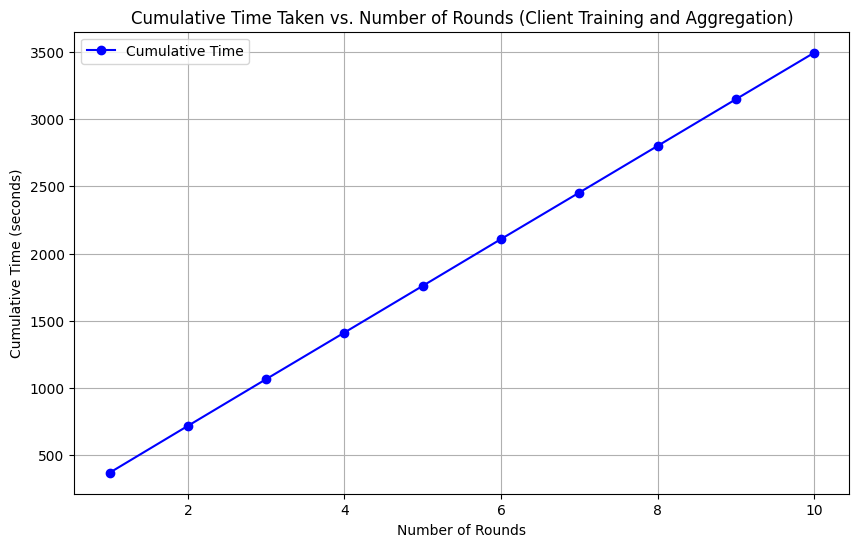

[(1, 370.43109226226807), (2, 348.5520327091217), (3, 347.50747632980347), (4, 346.2844707965851), (5, 347.0711553096771), (6, 347.8356680870056), (7, 345.72584414482117), (8, 346.76615738868713), (9, 346.94237637519836), (10, 345.81905484199524)]
Total time taken for 10 rounds (client training and aggregation): 3492.94 seconds
Average round duration: 349.29 seconds
[(1, 13.105086326599121), (2, 12.441460609436035), (3, 12.527012348175049), (4, 12.546772718429565), (5, 12.411904096603394), (6, 12.486181735992432), (7, 12.267166376113892), (8, 12.382226943969727), (9, 12.384196043014526), (10, 12.233806371688843)]
Average aggregation time: 12.48 seconds


In [ ]:
def plot_time_curve():

    global round_times ,aggregation_times

    if not round_times:
        print("No timing data collected during simulation.")
        return

    # Extract rounds and times
    rounds = [r for r, _ in round_times]
    times = [t for _, t in round_times]
    cumulative_times = np.cumsum(times)  # Compute cumulative time

    # Plot the results
    plt.figure(figsize=(10, 6))
    plt.plot(rounds, cumulative_times, marker='o', linestyle='-', color='b', label='Cumulative Time')
    plt.xlabel('Number of Rounds')
    plt.ylabel('Cumulative Time (seconds)')
    plt.title('Cumulative Time Taken vs. Number of Rounds (Client Training and Aggregation)')
    plt.grid(True)
    plt.legend()
    plt.show()

    # Display total time
    print(round_times)
    total_time = cumulative_times[-1]
    print(f"Total time taken for {len(rounds)} rounds (client training and aggregation): {total_time:.2f} seconds")
    avg_duration = sum(duration for _, duration in round_times) / len(round_times)
    print(f"Average round duration: {avg_duration:.2f} seconds")
    print(aggregation_times)
    avg_aggregation_time = sum(duration for _, duration in aggregation_times) / len(aggregation_times)
    print(f"Average aggregation time: {avg_aggregation_time:.2f} seconds")
plot_time_curve()
